src: https://youtu.be/hpfQE0bTeA4?si=fR8GVp1thaCmhqQF 

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2024-07-22 12:02:03.016795: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 12:02:03.068362: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 12:02:03.402449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 12:02:04.922999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [2]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "INTC"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime.now().date()
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.drop(columns=["symbol"], inplace=True)
data.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2016-01-04 05:00:00+00:00,26.96,27.06,26.62,27.05,32165978.0,122840.0,26.88
2016-01-05 05:00:00+00:00,27.02,27.05,26.68,26.92,17905707.0,87505.0,26.85
2016-01-06 05:00:00+00:00,26.46,26.67,26.10,26.32,26939523.0,121984.0,26.39
2016-01-07 05:00:00+00:00,25.68,26.26,25.33,25.33,41368839.0,163862.0,25.63
2016-01-08 05:00:00+00:00,25.53,25.64,25.01,25.07,32404640.0,142641.0,25.31


<Axes: xlabel='timestamp'>

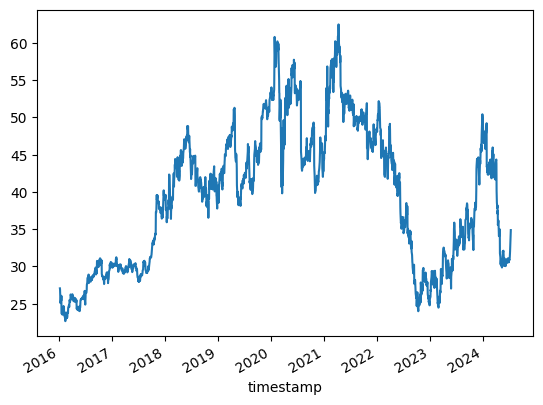

In [3]:
data["close"].plot()

In [4]:
data["target"] = data["close"].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(columns=["close", "timestamp"], axis=1, inplace=True)
data

,open,high,low,volume,trade_count,vwap,target
0,26.960,27.06,26.6200,32165978.0,122840.0,26.880000,26.92
1,27.020,27.05,26.6800,17905707.0,87505.0,26.850000,26.32
2,26.460,26.67,26.1000,26939523.0,121984.0,26.390000,25.33
3,25.680,26.26,25.3300,41368839.0,163862.0,25.630000,25.07
4,25.530,25.64,25.0100,32404640.0,142641.0,25.310000,25.51
...,...,...,...,...,...,...,...
2137,30.855,31.31,30.5850,35999280.0,160135.0,30.946336,31.23
2138,31.120,31.34,30.9100,24065673.0,110191.0,31.156702,32.02
2139,31.400,32.34,31.3114,45309446.0,239436.0,31.911269,33.99
2140,33.030,34.09,32.8200,82315937.0,465491.0,33.670468,34.59


In [5]:
data.shape

(2142, 7)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)
data_scaled.shape

(2142, 7)

In [7]:
lookback = 30
X = np.array([data_scaled[i-lookback:i,:len(data.columns)].copy() for i in range(lookback,len(data_scaled))])
X, yi = np.array(X)[:,:,:-1], np.array(data_scaled[lookback:,-1])
y=np.reshape(yi,(len(yi),1))

In [8]:
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

In [9]:
X_train.shape, y_train.shape

((1689, 30, 6), (1689, 1))

In [10]:
X_test.shape, y_test.shape

((423, 30, 6), (423, 1))

In [11]:

np.random.seed(10)

lstm_input = keras.Input(shape=(lookback, len(data.columns)-1), name='lstm_input')
inputs = layers.LSTM(150, name='first_layer')(lstm_input)
inputs = layers.Dense(1, name='dense_layer')(inputs)
output = layers.Activation('linear', name='output')(inputs)
model = keras.Model(inputs=lstm_input, outputs=output)
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0234 - val_loss: 0.0017
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 9/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 9.6244e-04 - val_loss: 0.0014
Epoch 10/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 11/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/30
102/102 ━━━━━━━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


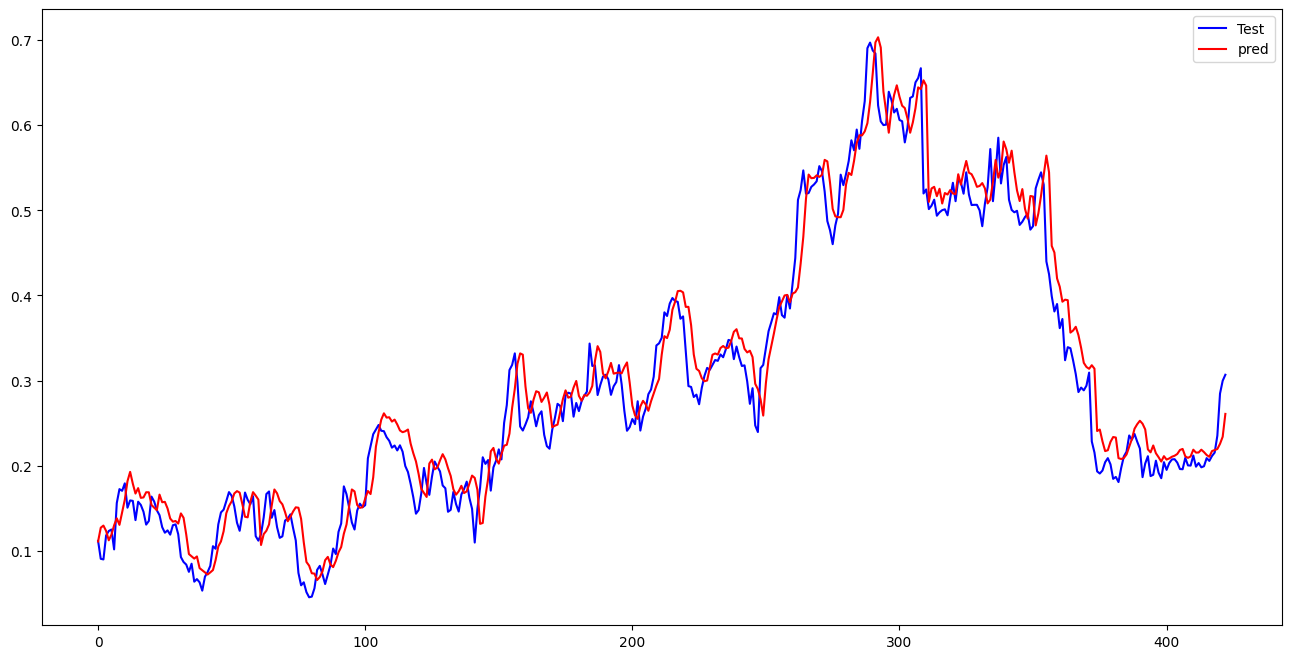

In [14]:
y_pred = model.predict(X_test)
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()